# Uncertainties on dust parameters from color-temperature method
### January 23, 2022
### Ramsey Karim

I want to see how flux uncertainties propagate through the splines I use for the dust parameters.

## 1.1 Standard deviation of the background regions

I am using the flux background subtraction method here, since that's what I've been asked to use for this project. If I switch to another method, the error calculation will be slightly different.

The flux subtraction should have an associated error.
To find that, I will first follow `g0_dust.find_pacs_background_near_pillars` to calculate the standard deviation across the background regions.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import glob

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
import regions
from astropy import units as u
from astropy.modeling import models

from scipy.interpolate import UnivariateSpline

from mantipython.physics import greybody, dust, instrument

In [2]:
pacs_obs_dir = "/home/ramsey/Documents/Research/Feedback/m16_data/herschel/processed/1342218995_reproc160"

def make_pacs_fn(band, ie='image'):
    # ie: image or error
    return os.path.join(pacs_obs_dir, f"PACS{band}um-{ie}-remapped-conv.fits")

bands = (70, 160)

In [3]:
def load_background_regions(bg_type):
    # Just load background regions. bg_type can be all, north, or south
    bg_reg_list = regions.Regions.read("/home/ramsey/Documents/Research/Feedback/m16_data/catalogs/pillar_background_sample_multiple_5.reg")
    if bg_type == 'north':
        bg_reg_list = bg_reg_list[:4]
    elif bg_type == 'south':
        bg_reg_list = bg_reg_list[4:]
    else:
        bg_reg_list = bg_reg_list
    return bg_reg_list

In [4]:
def assemble_region_mask(reg_list, wcs_object):
    mask_list = [reg.to_pixel(wcs_object).to_mask().to_image(wcs_object.array_shape) for reg in reg_list]
    return np.any(mask_list, axis=0)

In [5]:
def load_and_check_background(band, ax=None, bg_type='all'):
    fn = make_pacs_fn(band)
    img, hdr = fits.getdata(fn, header=True)
    w = WCS(hdr)
    finite_mask = np.isfinite(img)
    
    # Load the correct backgrounds
    bg_reg_list = load_background_regions(bg_type)
    
    # Mask and get stats
    bg_mask = assemble_region_mask(bg_reg_list, w)
    bg_vals = img[finite_mask & bg_mask]
    mean_bg = np.mean(bg_vals)
    median_bg = np.median(bg_vals)
    std_bg = np.std(bg_vals)

    # Plot
    if ax is None:
        ax = plt.subplot(111)
    ax.hist(bg_vals.ravel())
    ax.axvline(mean_bg, label=f'mean {mean_bg:.2f}', color='orange', zorder=999)
    ax.axvline(median_bg, label=f'median {median_bg:.2f}', color='cyan', zorder=999)
    ax.axvline(mean_bg-std_bg, label=f'std {std_bg:.2f}', color='k')
    ax.axvline(mean_bg+std_bg, color='k')
    
    ax.set_xlabel(f"Background flux {band}um")
    ax.set_ylabel("Histogram count")
    
    ax.set_title(f"{bg_type} background")
    ax.legend()

In [6]:
def run_all(i, limits=None):
    b = bands[i]
    fig = plt.figure(figsize=(15, 5))
    ax1, ax2, ax3 = plt.subplot(131), plt.subplot(132), plt.subplot(133)
    load_and_check_background(b, bg_type='north', ax=ax1)
    load_and_check_background(b, bg_type='south', ax=ax2)
    load_and_check_background(b, bg_type='all', ax=ax3)
    if limits is not None:
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(limits)

The figures below show the `north`, `south` and `all` (combined) background statistics for 70 and 160$\mu$m. The mean and median are overlayed. The standard deviation is overlayed as $\mu \pm \sigma$ on either side of the mean.

Set MJD-END to 55661.334519 from DATE-END'. [astropy.wcs.wcs]


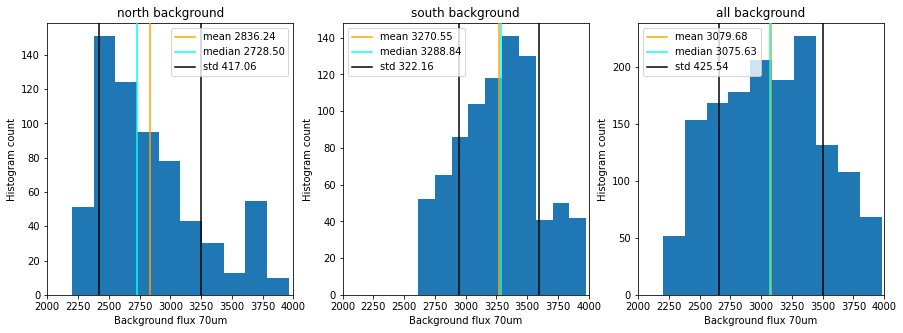

In [7]:
run_all(0, limits=[2000, 4000])

Set MJD-END to 55661.334520 from DATE-END'. [astropy.wcs.wcs]


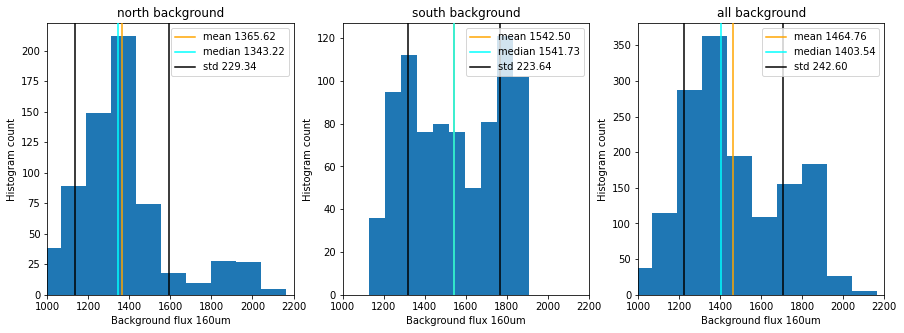

In [8]:
run_all(1, limits=[1000, 2200])

## 1.2 Statistical flux uncertainties stated for these data

The archived PACS photometry comes with an extension labelled "stDev", implying that it is the standard deviation of the scans that comprise the observations. I interpret this to be the error map.

The 70$\mu$m image and error maps have been regridded and convolved to the 160$\mu$m grid and resolution, so the errors are somewhat smoothed out. This is due to beam smearing. The "averaging" effect of regridding and convolution (which should suppress error) has not been explicitly dealt with.

Set MJD-END to 55661.334520 from DATE-END'. [astropy.wcs.wcs]


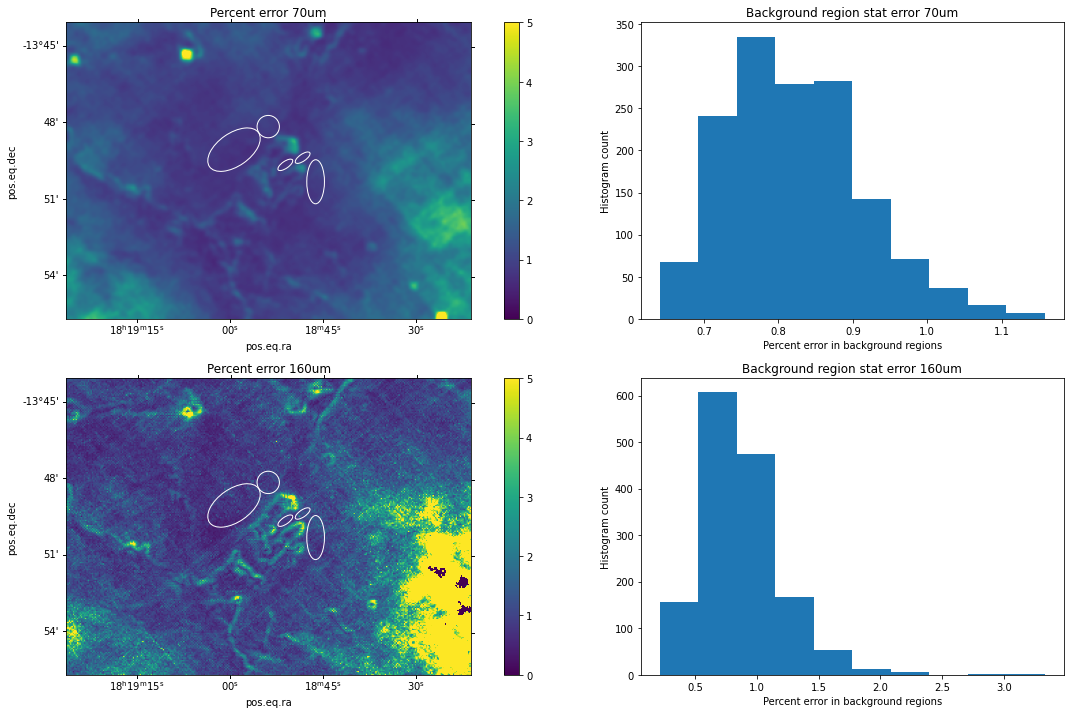

In [9]:
# Cutout parameters
center = (2867, 1745-30)
size = (1192//4, 873//4)

fig = plt.figure(figsize=(20, 12))
grid_shape = (2, 5)
make_img_ax = lambda i, wcs_object : plt.subplot2grid(grid_shape, (i, 0), colspan=3, projection=wcs_object)
make_hist_ax = lambda i : plt.subplot2grid(grid_shape, (i, 3), colspan=2)

# Save the cutout versions of these for later
band_images = {}
band_errors = {}

for i, band in enumerate(bands):
    fn_i = make_pacs_fn(band, ie='image')
    fn_e = make_pacs_fn(band, ie='error')
    
    img, hdr = fits.getdata(fn_i, header=True)
    err = fits.getdata(fn_e) # same WCS, skip the header
    original_wcs = WCS(hdr)
    img_cutout = Cutout2D(img, center, size[::-1], wcs=original_wcs)
    img = img_cutout.data
    err = err[img_cutout.slices_original]
    wcs_object = img_cutout.wcs
    pct_err = 100*err/img

    band_images[band] = img
    band_errors[band] = err
    
    ax = make_img_ax(i, wcs_object)
    im = ax.imshow(pct_err, origin='lower', vmin=0, vmax=5)
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Percent error {band}um")

    bg_reg_list = load_background_regions('all')
    for reg in bg_reg_list:
        ax.add_artist(reg.to_pixel(wcs_object).as_artist(fc='none', ec='w'))

    bg_mask = assemble_region_mask(bg_reg_list, wcs_object)

    hax = make_hist_ax(i)
    hax.hist(pct_err[bg_mask].ravel())
    hax.set_title(f"Background region stat error {band}um")
    hax.set_xlabel("Percent error in background regions")
    hax.set_ylabel("Histogram count")


## 1.3 Summary and total uncertainty

There are three sources of uncertainty we will consider:
* A combination of statistical (pixel noise) and systematic (real background variation) uncertainties total to 417.06 MJy/sr at 70$\mu$m and 229.34 MJy/sr at 160$\mu$m.
* The error plane attached to the observations shows that statistical error reaches about 5% of the flux over parts of the pillars and is less than 1.5% in the background regions.
* The PACS handbook states a 5% systematic uncertainty in the absolute flux calibration.

The background variation is about 15% of the mean background in each band.
This dominates the 1.5% statistical and 5% systematic for the background samples.
However, the $\leq$5% statistical error scales (more than linearly) with flux, so pillar uncertainties may be dominated by statistical uncertainty rather than background uncertainty.

I will consider the statistical uncertainty to be 5% everwhere, since I care about the pillars and it is $\sim$5% over the pillars.
I will wrap in the flat 5% systematic flux calibration uncertainty from the handbook, making the total fractional uncertainty $\approx$7%.
I take the 7% from the *total archival flux*, with no zero-point corrections.

The figures below show the total uncertainty, the background variation plus 7% of the flux, as a percentage of the *background-corrected* flux.
A contour is placed where the background variation equals the 7% uncertainty, so **the areas inside the contours are where the 7% uncertainty dominates over systematic background varation uncertainty.**
Note that the background samples are taken near the pillars, so they aren't valid further away (where fractional error blows up).

What we find is that statistical uncertainty ($\leq$5% of flux) is only greater than background variation in small areas, mostly the bright, massive heads of pillars.
These are the areas we are interested in, so for the most part, our uncertainty is dominated by the 5% statistical + 5% flat systematic.

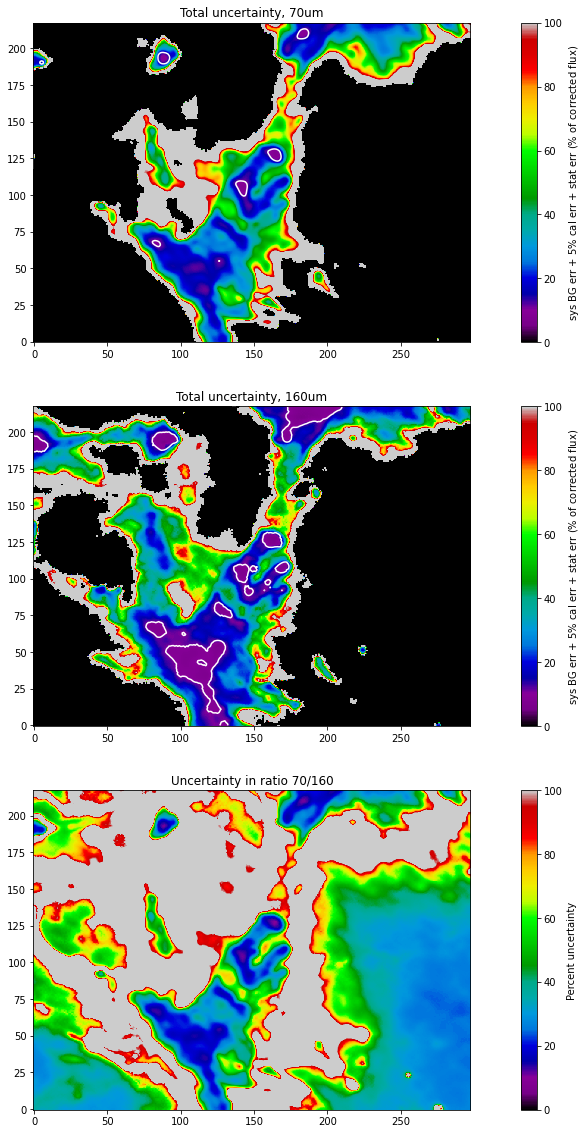

In [11]:
fig = plt.figure(figsize=(18, 20))
axes = [plt.subplot(311), plt.subplot(312)]
bg_var_errs = [416.06, 229.34]
bg_means = [2836.24, 1365.62]

total_err_maps = {}
frac_err_maps = {}
corrected_img_maps = {}
for i, band in enumerate(bands):
    img = band_images[band]
    abs_cal_err = img*0.05
    stat_err = band_errors[band]
    abs_and_stat_err = abs_cal_err**2 + stat_err**2 # squared, to save flops
    total_err = np.sqrt(abs_and_stat_err + bg_var_errs[i]**2)
    abs_and_stat_err = np.sqrt(abs_and_stat_err) # not squared anymore
    total_err_maps[band] = total_err

    ax = axes[i]
    corrected_img = (img - bg_means[i])
    corrected_img_maps[band] = corrected_img
    frac_err = total_err/corrected_img
    frac_err_maps[band] = frac_err
    im = ax.imshow(frac_err*100, origin='lower', vmin=0, vmax=100, cmap='nipy_spectral')
    fig.colorbar(im, ax=ax, label='sys BG err $+$ 5% cal err + stat err (% of corrected flux)')
    ax.contour(abs_and_stat_err, levels=[bg_var_errs[i]], colors='w')
    ax.set_title(f"Total uncertainty, {band}um")

# Plot the fractional uncertainty in the ratio of 70/160    
ax = plt.subplot(313)
frac_ratio_err = np.sqrt(frac_err_maps[70]**2 + frac_err_maps[160]**2)
im = ax.imshow(frac_ratio_err*100, origin='lower', vmin=0, vmax=100, cmap='nipy_spectral')
ax.set_title("Uncertainty in ratio 70/160")
fig.colorbar(im, ax=ax, label='Percent uncertainty')

# Calculate the flux ratio for the next step
ratio_map = corrected_img_maps[70] / corrected_img_maps[160]
absolute_ratio_err = frac_ratio_err * ratio_map
p160_map = corrected_img_maps[160]
realistic_value_mask = np.all([x>0 for x in corrected_img_maps.values()], axis=0)
# Also signal to noise on the corrected images
# band_corrected_images = {}
band_snrs = {}
for band in bands:
#     band_corrected_images[band] = corrected_img
    band_snrs[band] = corrected_img_maps[band] / band_errors[band]

## 2. Ratio and uncertainty values

The last plot above shows the percentage error in ratio. The two plots below show the actual ratio values and uncertainties.

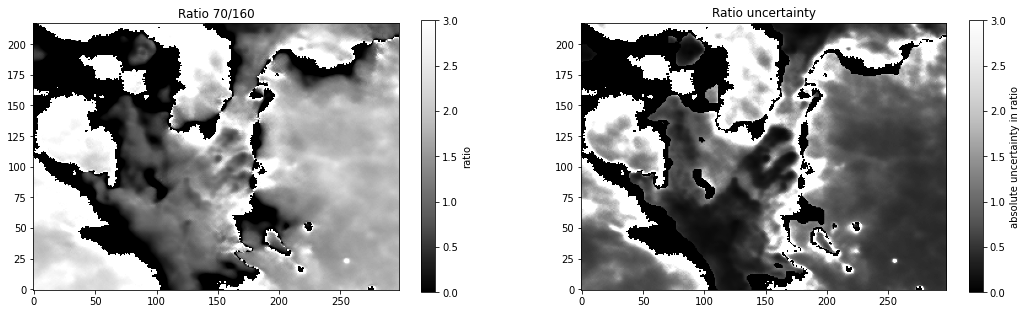

In [12]:
fig = plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
im = ax1.imshow(ratio_map, origin='lower', vmin=0, vmax=3, cmap='Greys_r')
fig.colorbar(im, ax=ax1, label='ratio')
ax1.set_title("Ratio 70/160")

ax2 = plt.subplot(122)
im = ax2.imshow(absolute_ratio_err, origin='lower', vmin=0, vmax=3, cmap='Greys_r')
fig.colorbar(im, ax=ax2, label='absolute uncertainty in ratio')
ax2.set_title("Ratio uncertainty");

## 3. Uncertainty on temperature and column density

I can use the uncertainty on the flux ratio to estimate uncertainty on the temperature.
I can then test uncertainty on optical depth (which will be directly proportional to column density)

The code below is largely from `solve_colortemperature.ipynb`.

In [13]:
pacs_freqs = (bands * u.micron).to(u.Hz, equivalencies=u.spectral())
model_T_arr = np.arange(1, 200, 0.1) # units of K

p70_detector, p160_detector = instrument.get_instrument(bands)

# Make the two interpolation arrays
model_bandpass_br_ratio = np.zeros_like(model_T_arr)
zerotau_160intensity = np.zeros_like(model_T_arr)
args1 = (-8., dust.TauOpacity(2.)) # here so we only init TauOpac once
args2 = (0, dust.TauOpacity(2.)) # (twice, but better than 4000x)
for i, t in enumerate(model_T_arr):
    # First ratio -> T
    g = greybody.Greybody(t, *args1)
    p70_I = p70_detector.detect(g)
    p160_I = p160_detector.detect(g)
    model_bandpass_br_ratio[i] = p70_I / p160_I
    # Then T -> zerotau_160 (perfect blackbody intensity)
    zerotau_160intensity[i] = p160_detector.detect(greybody.ThinGreybody(t, *args2))

model_bandpass_br_spline = UnivariateSpline(model_bandpass_br_ratio, model_T_arr, s=0)
zerotau_I_spline = UnivariateSpline(model_T_arr, zerotau_160intensity, s=0)

### How linear are the relationships with color and temperature?

The plots below show that the relationships between color and temperature and optical depth and temperature are somewhat non-linear around 25 K, which is the relevant temperature regime for the pillars.

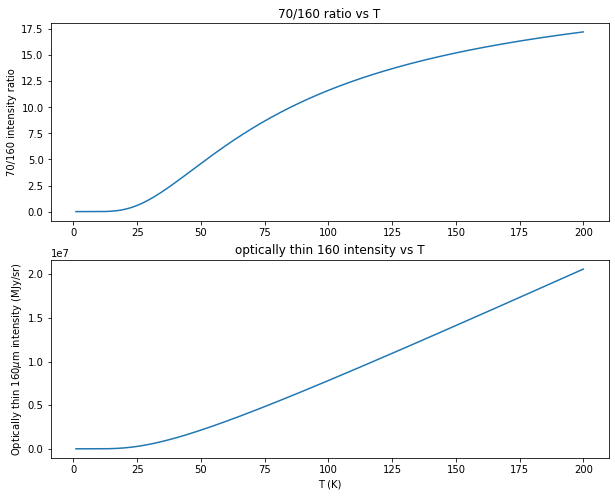

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(model_T_arr, model_bandpass_br_ratio)
plt.title("70/160 ratio vs T")
# plt.xlabel("T (K)")
plt.ylabel("70/160 intensity ratio")
plt.subplot(212)
plt.plot(model_T_arr, zerotau_160intensity)
plt.title("optically thin 160 intensity vs T")
plt.xlabel("T (K)")
plt.ylabel("Optically thin 160$\mu$m intensity (MJy/sr)");

## 3.1 Temperature and its upper and lower error bars

The plots below show $T$ and the uncertainties.
We see that the brightest locations are the most stable

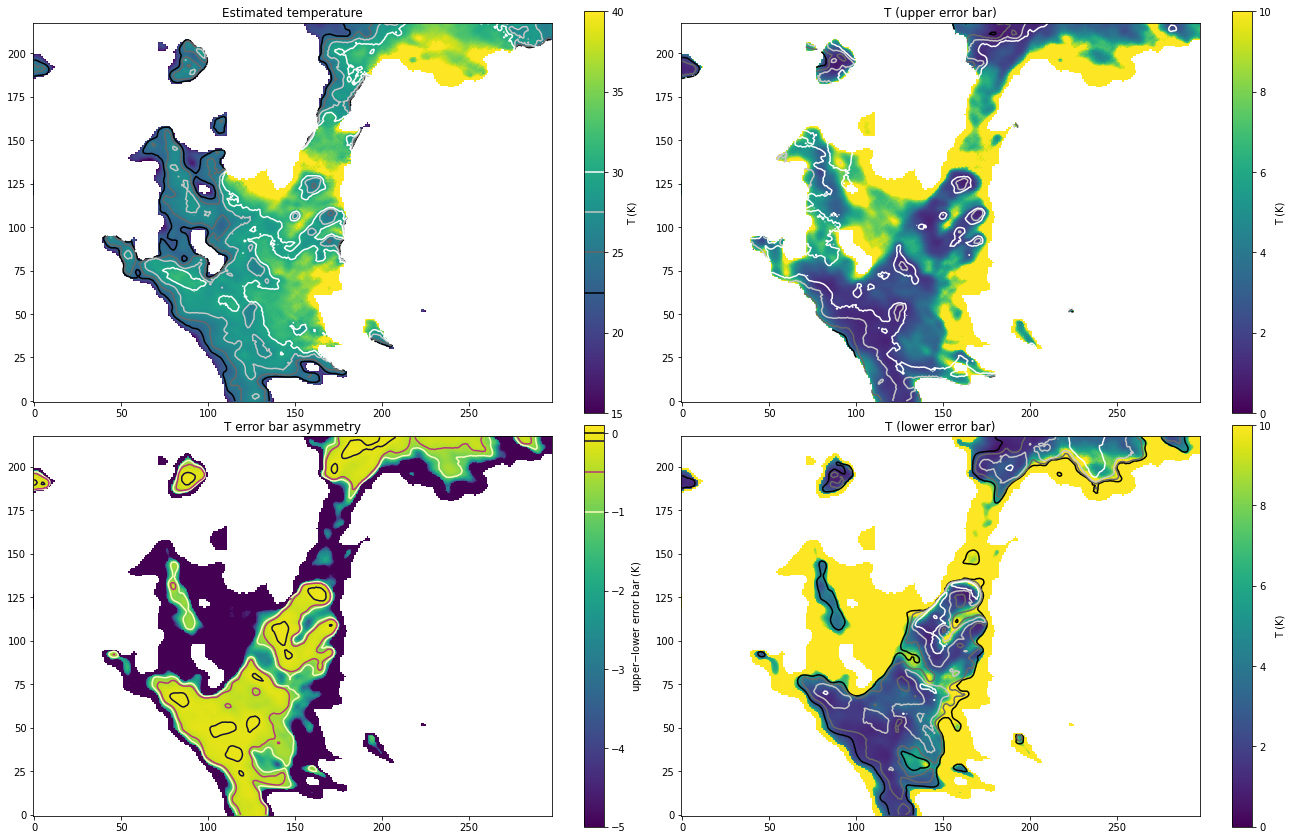

In [15]:
# Apply splines to the observations to get physical properties
ratio_map_copy = ratio_map.copy()
ratio_map_copy[~realistic_value_mask] = np.nan
T_map = model_bandpass_br_spline(ratio_map_copy)

image_cmap = 'viridis'
contour_cmap = 'Greys_r'
imlo, imhi = 15, 40

grid_shape = (2, 2)
fig = plt.figure(figsize=(20, 15))
ax0 = plt.subplot2grid(grid_shape, (0, 0))

im = ax0.imshow(T_map, origin='lower', vmin=imlo, vmax=imhi, cmap=image_cmap)
ax0.set_title("Estimated temperature")
cbar = fig.colorbar(im, ax=ax0, label='T (K)')
clevels = [22.5, 25, 27.5, 30]
ax0.contour(T_map, levels=clevels, cmap=contour_cmap)
norm = matplotlib.colors.Normalize(clevels[0], clevels[-1])
cmap = matplotlib.cm.get_cmap(contour_cmap)
def mark_colorbar(cbar, clevels=clevels, cmap=cmap, norm=norm):
    for cl in clevels:
        cbar.ax.plot([0, 1], [cl]*2, color=cmap(norm(cl)))
mark_colorbar(cbar)

ax1 = plt.subplot2grid(grid_shape, (1, 1))
ax2 = plt.subplot2grid(grid_shape, (0, 1))
ax3 = plt.subplot2grid(grid_shape, (1, 0))

T_map_lo = model_bandpass_br_spline(ratio_map_copy - absolute_ratio_err)
T_lower_bar = T_map - T_map_lo
T_map_hi = model_bandpass_br_spline(ratio_map_copy + absolute_ratio_err)
T_upper_bar = T_map_hi - T_map


# im = ax2.imshow(band_snrs[70], origin='lower', vmin=0, vmax=100)
# ax2.set_title("SNR")
# ax2.contour(band_snrs[70], levels=[3, 5, 10, 15], colors='w')
# fig.colorbar(im, ax=ax2, label='signal to noise')

im = ax1.imshow(T_lower_bar, origin='lower',
#                 vmin=imlo, vmax=imhi,
                vmin=0, vmax=10,
                cmap=image_cmap)
ax1.contour(T_map_lo, levels=clevels, cmap=contour_cmap)
cbar = fig.colorbar(im, ax=ax1, label='T (K)')
mark_colorbar(cbar)
ax1.set_title("T (lower error bar)")

im = ax2.imshow(T_upper_bar, origin='lower',
#                 vmin=imlo, vmax=imhi,
                vmin=0, vmax=10,
                cmap=image_cmap)
ax2.contour(T_map_hi, levels=clevels, cmap=contour_cmap)
cbar = fig.colorbar(im, ax=ax2, label='T (K)')
mark_colorbar(cbar)
ax2.set_title("T (upper error bar)")



cmap_name = 'magma_r'
im = ax3.imshow(T_upper_bar - T_lower_bar, origin='lower', vmin=-5, vmax=0.1, cmap='viridis')
ax3.set_title("T error bar asymmetry")
cbar = fig.colorbar(im, ax=ax3, label='upper$-$lower error bar (K)')
clevels = [-1, -0.5, -0.1, 0]
ax3.contour(T_upper_bar - T_lower_bar, levels=clevels, cmap=cmap_name)
norm = matplotlib.colors.Normalize(clevels[0], clevels[-1])
cmap = matplotlib.cm.get_cmap(cmap_name)
mark_colorbar(cbar, clevels=clevels, cmap=cmap, norm=norm)


plt.subplots_adjust(hspace=0.03, wspace=0, left=0)

## 3.2 Uncertainty in optical depth

Optical depth is calculated by dividing the observed 160$\mu$m flux by the 160$\mu$m flux of a $T$ greybody unmodified by optical depth. (See Tiwari 2021 equations)

I will check the "worst case scenario" uncertainty: highest temperature + lowest 160 flux (lowest optical depth), and lowest temperature + highest 160 flux (highest optical depth). Then I'll do something more nuanced once I know how bad things can get.

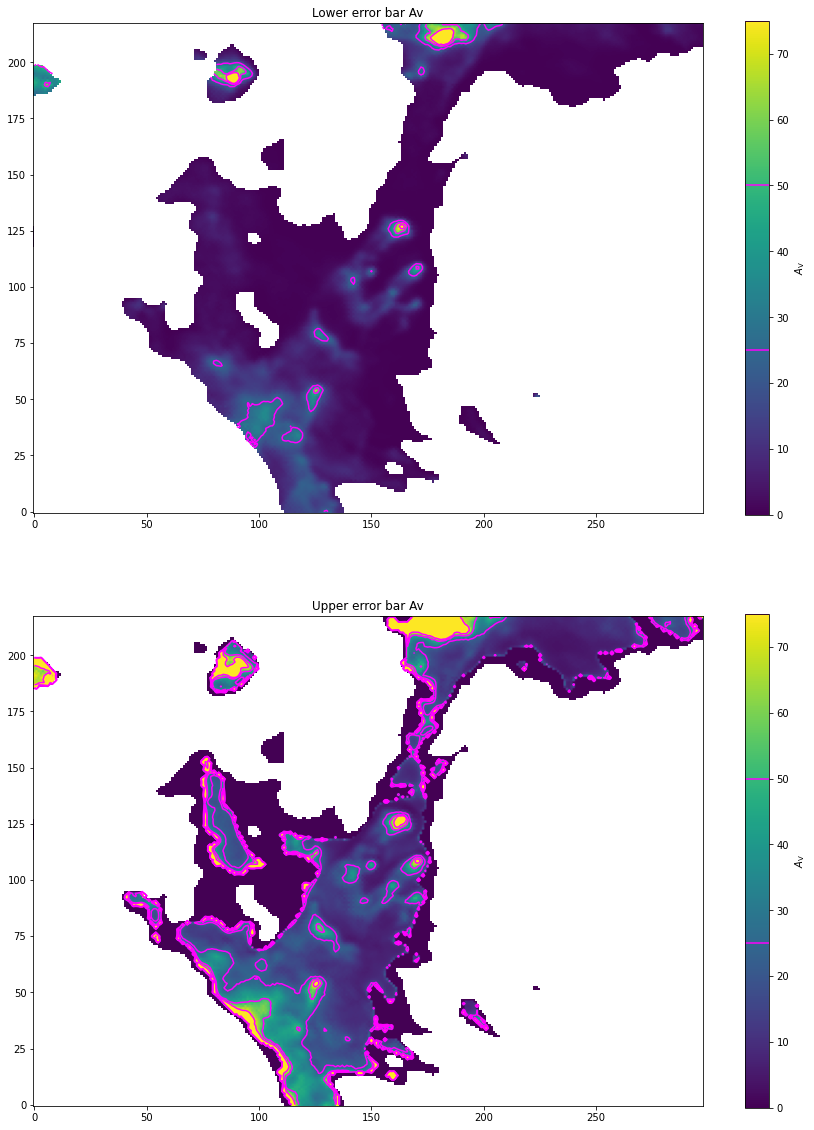

In [46]:
err_160 = total_err_maps[160]
img_160 = corrected_img_maps[160]

# Lowest optical depth case
tau_map_lo = (img_160 - err_160) / zerotau_I_spline(T_map_hi)
# Highest optical depth case
tau_map_hi = (img_160 + err_160) / zerotau_I_spline(T_map_lo)

# Cext/H is 1.9e-25 cm2. N(H) = 1.9e21 cm-2 Av
tau_to_Av_conversion = lambda t : t / (1.9e-25 * 1.9e21)

fig = plt.figure(figsize=(15, 20))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

Av_lo = tau_to_Av_conversion(tau_map_lo)
im = ax1.imshow(Av_lo, origin='lower', vmin=0, vmax=75)
cbar = fig.colorbar(im, ax=ax1, label='$A_{\\rm V}$')
ax1.set_title("Lower error bar Av")
levels = [25, 50, 75]
ax1.contour(Av_lo, levels=levels, colors='magenta')
def mark_cbar(cbar):
    for l in levels:
        cbar.ax.plot([0, 1], [l]*2, color='magenta')
mark_cbar(cbar)

Av_hi = tau_to_Av_conversion(tau_map_hi)
im = ax2.imshow(Av_hi, origin='lower', vmin=0, vmax=75)
cbar = fig.colorbar(im, ax=ax2, label='$A_{\\rm V}$')
ax2.set_title("Upper error bar Av")
ax2.contour(Av_hi, levels=levels, colors='magenta')
mark_cbar(cbar)

So that's what the sort of "limits" look like, now I'll see what the error bars appear to be (difference from "best" value)

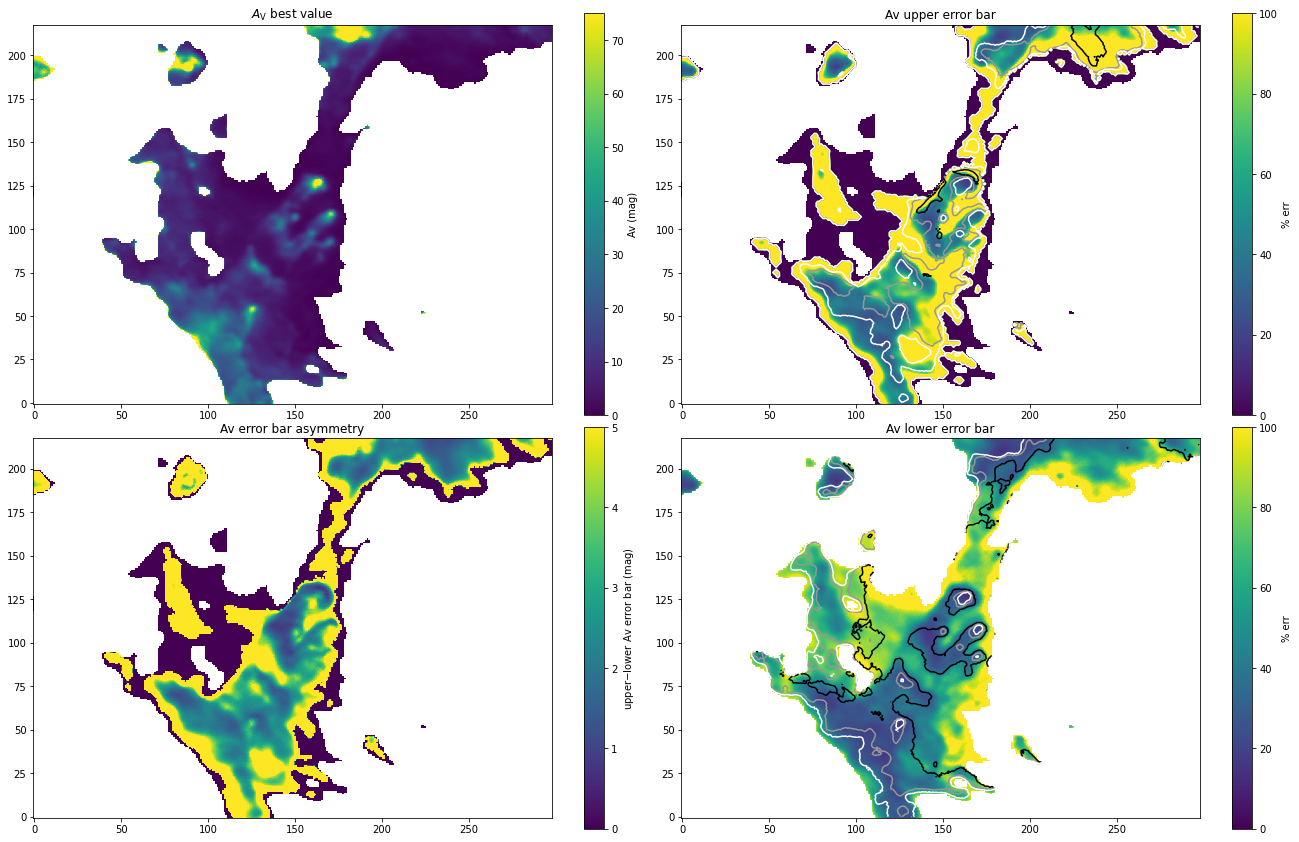

In [78]:
fig = plt.figure(figsize=(20, 15))

tau_map = img_160 / zerotau_I_spline(T_map) # "best value" tau
Av_map = tau_to_Av_conversion(tau_map)

Av_lower_bar = Av_map - Av_lo
Av_upper_bar = Av_hi - Av_map
Av_asymm = Av_upper_bar - Av_lower_bar

grid_shape = (2, 2)
ax0 = plt.subplot2grid(grid_shape, (0, 0)) # best value
ax1 = plt.subplot2grid(grid_shape, (0, 1)) # upper bar
ax2 = plt.subplot2grid(grid_shape, (1, 1)) # lower bar
ax3 = plt.subplot2grid(grid_shape, (1, 0)) # asymmetry

im = ax0.imshow(Av_map, origin='lower', vmin=0, vmax=75)
ax0.set_title("$A_{\\rm V}$ best value")
fig.colorbar(im, ax=ax0, label='Av (mag)')


levels = [3, 6, 9]

im = ax1.imshow(Av_upper_bar*100/Av_map, origin='lower', vmin=0, vmax=100)
ax1.set_title("Av upper error bar")
cbar = fig.colorbar(im, ax=ax1, label='% err')
ax1.contour(Av_upper_bar, levels=levels, cmap='Greys_r')

im = ax2.imshow(Av_lower_bar*100/Av_map, origin='lower', vmin=0, vmax=100)
ax2.set_title("Av lower error bar")
cbar = fig.colorbar(im, ax=ax2, label='% err')
ax2.contour(Av_lower_bar, levels=levels, cmap='Greys_r')

im = ax3.imshow(Av_asymm, origin='lower', vmin=0, vmax=5)
ax3.set_title("Av error bar asymmetry")
fig.colorbar(im, ax=ax3, label='upper$-$lower Av error bar (mag)')

plt.subplots_adjust(hspace=0.03, wspace=0, left=0)

So there's like 20% uncertainty on the optical depth / Av / column density.
But some of this is statistical, which should shrink with integration over pixels, and some is systematic (calibration accuracy and background variation) and should not shrink with integration over pixels. How do I separate those out?